## 1. Configuración del Entorno

# Entrega 2 - Preprocesado de Datos

## Proyecto: Pruebas Saber Pro Colombia

In [299]:
# Instalación de librerías necesarias
!pip install kaggle pandas numpy matplotlib seaborn scikit-learn fuzzywuzzy python-Levenshtein unidecode --quiet


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [300]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from fuzzywuzzy import fuzz, process
from unidecode import unidecode

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

## 2. Configuración de Kaggle API

Configuramos las credenciales de Kaggle para poder descargar los datos de la competencia.

In [301]:
# Crear directorio para credenciales de Kaggle
import os
import json

# Crear directorio .kaggle si no existe
kaggle_dir = os.path.expanduser('~/.kaggle')
os.makedirs(kaggle_dir, exist_ok=True)

# Credenciales de Kaggle
kaggle_credentials = {
    "username": "juanjosecortesfa",
    "key": "0f8cebc5ec0322e132f836eb1d2ea475"
}

# Guardar credenciales
kaggle_json_path = os.path.join(kaggle_dir, 'kaggle.json')
with open(kaggle_json_path, 'w') as f:
    json.dump(kaggle_credentials, f)

# Establecer permisos correctos (solo lectura para el usuario)
os.chmod(kaggle_json_path, 0o600)

print("✓ Credenciales de Kaggle configuradas correctamente")

✓ Credenciales de Kaggle configuradas correctamente


## 3. Descarga de Datos desde Kaggle

**IMPORTANTE:** Antes de ejecutar esta celda, debes:
1. Ir a la competencia: https://www.kaggle.com/competitions/udea-ai-4-eng-20252-pruebas-saber-pro-colombia
2. Hacer clic en **"Join Competition"** y aceptar las reglas
3. Sin este paso, obtendrás un error 403 Forbidden

In [302]:
import subprocess
import zipfile
from pathlib import Path

# Configuración
data_dir = Path('data')
competition_name = 'udea-ai-4-eng-20252-pruebas-saber-pro-colombia'
zip_file = Path(f'{competition_name}.zip')

# Crear directorio
data_dir.mkdir(exist_ok=True)

# Descargar datos
print("Descargando datos de Kaggle...")
subprocess.run(['kaggle', 'competitions', 'download', '-c', competition_name])

# Descomprimir
print(f"\nDescomprimiendo {zip_file}...")
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(data_dir)

# Listar archivos
print("\nArchivos disponibles en ./data/:")
for file in sorted(data_dir.iterdir()):
    size_mb = file.stat().st_size / (1024 * 1024)
    print(f"  - {file.name:40s} ({size_mb:6.2f} MB)")


Descargando datos de Kaggle...

Descomprimiendo udea-ai-4-eng-20252-pruebas-saber-pro-colombia.zip...

Archivos disponibles en ./data/:
  - submission_example.csv                   (  4.50 MB)
  - test.csv                                 ( 56.44 MB)
  - train.csv                                (137.07 MB)


## 4. Carga de Datos

In [303]:
# Cargar dataset de entrenamiento
from pathlib import Path

train_file = Path('./data/train.csv')

df = pd.read_csv(train_file)
print(f"✓ Dataset cargado exitosamente")
print(f"\nDimensiones del dataset: {df.shape}")
print(f"Filas: {df.shape[0]:,}")
print(f"Columnas: {df.shape[1]}")

✓ Dataset cargado exitosamente

Dimensiones del dataset: (692500, 21)
Filas: 692,500
Columnas: 21


In [304]:
# Vista general del dataset
df.head()

,ID,PERIODO_ACADEMICO,E_PRGM_ACADEMICO,E_PRGM_DEPARTAMENTO,E_VALORMATRICULAUNIVERSIDAD,E_HORASSEMANATRABAJA,F_ESTRATOVIVIENDA,F_TIENEINTERNET,F_EDUCACIONPADRE,F_TIENELAVADORA,F_TIENEAUTOMOVIL,E_PRIVADO_LIBERTAD,E_PAGOMATRICULAPROPIO,F_TIENECOMPUTADOR,F_TIENEINTERNET.1,F_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,INDICADOR_1,INDICADOR_2,INDICADOR_3,INDICADOR_4
0,904256,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Si,Si,N,No,Si,Si,Postgrado,medio-alto,0.322,0.208,0.310,0.267
1,645256,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Si,No,N,No,Si,No,Técnica o tecnológica incompleta,bajo,0.311,0.215,0.292,0.264
2,308367,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,No,N,No,No,Si,Secundaria (Bachillerato) completa,bajo,0.297,0.214,0.305,0.264
3,470353,20195,ADMINISTRACION DE EMPRESAS,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Si,No,N,No,Si,Si,Secundaria (Bachillerato) completa,alto,0.485,0.172,0.252,0.190
4,989032,20212,PSICOLOGIA,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Si,Si,N,No,Si,Si,Primaria completa,medio-bajo,0.316,0.232,0.285,0.294


## 5. Análisis Exploratorio de Columnas Categóricas

In [322]:
# Información general del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692500 entries, 0 to 692499
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   ID                           692500 non-null  int64  
 1   PERIODO_ACADEMICO            692500 non-null  int64  
 2   E_PRGM_ACADEMICO             692500 non-null  object 
 3   E_PRGM_DEPARTAMENTO          692500 non-null  object 
 4   E_VALORMATRICULAUNIVERSIDAD  686213 non-null  object 
 5   E_HORASSEMANATRABAJA         661643 non-null  object 
 6   F_ESTRATOVIVIENDA            660363 non-null  object 
 7   F_TIENEINTERNET              665871 non-null  object 
 8   F_EDUCACIONPADRE             669322 non-null  object 
 9   F_TIENELAVADORA              652727 non-null  object 
 10  F_TIENEAUTOMOVIL             648877 non-null  object 
 11  E_PRIVADO_LIBERTAD           692500 non-null  object 
 12  E_PAGOMATRICULAPROPIO        686002 non-null  object 
 13 

### 5.1 Identificación de Columnas Categóricas

In [323]:
# Identificar columnas por tipo
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Columnas categóricas ({len(categorical_cols)}):")
for col in categorical_cols:
    print(f"  - {col}")

print(f"\nColumnas numéricas ({len(numerical_cols)}):")
for col in numerical_cols:
    print(f"  - {col}")

Columnas categóricas (15):
  - E_PRGM_ACADEMICO
  - E_PRGM_DEPARTAMENTO
  - E_VALORMATRICULAUNIVERSIDAD
  - E_HORASSEMANATRABAJA
  - F_ESTRATOVIVIENDA
  - F_TIENEINTERNET
  - F_EDUCACIONPADRE
  - F_TIENELAVADORA
  - F_TIENEAUTOMOVIL
  - E_PRIVADO_LIBERTAD
  - E_PAGOMATRICULAPROPIO
  - F_TIENECOMPUTADOR
  - F_TIENEINTERNET.1
  - F_EDUCACIONMADRE
  - RENDIMIENTO_GLOBAL

Columnas numéricas (6):
  - ID
  - PERIODO_ACADEMICO
  - INDICADOR_1
  - INDICADOR_2
  - INDICADOR_3
  - INDICADOR_4


### 5.2 Análisis Detallado de Cada Columna Categórica

Para cada columna categórica analizaremos:
- Número de valores únicos
- Valores faltantes
- Distribución de frecuencias
- Inconsistencias potenciales (variaciones ortográficas, espacios, mayúsculas, etc.)

In [324]:
def analizar_columna_categorica(df, col_name):
    """
    Analiza en detalle una columna categórica.
    """
    print(f"\n{'='*80}")
    print(f"ANÁLISIS: {col_name}")
    print(f"{'='*80}\n")
    
    # Información básica
    total = len(df)
    n_unique = df[col_name].nunique()
    n_missing = df[col_name].isna().sum()
    pct_missing = (n_missing / total) * 100
    
    print(f"Valores únicos: {n_unique:,}")
    print(f"Valores faltantes: {n_missing:,} ({pct_missing:.2f}%)")
    
    # Distribución de frecuencias (top 10)
    print(f"\nTop 10 valores más frecuentes:")
    value_counts = df[col_name].value_counts().head(10)
    for val, count in value_counts.items():
        pct = (count / total) * 100
        print(f"  {val:50s} -> {count:6,} ({pct:5.2f}%)")
    
    # Detección de posibles inconsistencias
    print(f"\n--- Análisis de Inconsistencias ---")
    
    # Verificar espacios al inicio/final
    with_leading_trailing = df[col_name].dropna().apply(
        lambda x: x != x.strip() if isinstance(x, str) else False
    ).sum()
    if with_leading_trailing > 0:
        print(f"⚠️  {with_leading_trailing:,} valores con espacios al inicio/final")
    
    # Verificar espacios múltiples
    with_multiple_spaces = df[col_name].dropna().apply(
        lambda x: bool(re.search(r'\s{2,}', str(x)))
    ).sum()
    if with_multiple_spaces > 0:
        print(f"⚠️  {with_multiple_spaces:,} valores con múltiples espacios")
    
    # Verificar inconsistencias de mayúsculas/minúsculas
    unique_values = df[col_name].dropna().unique()
    unique_lower = df[col_name].dropna().str.lower().unique()
    if len(unique_values) != len(unique_lower):
        diff = len(unique_values) - len(unique_lower)
        print(f"⚠️  {diff} valores duplicados por diferencias en mayúsculas/minúsculas")
    
    # Buscar posibles variaciones similares
    if n_unique <= 500:  # Solo para columnas con pocos valores únicos
        print(f"\n--- Búsqueda de Variaciones Similares ---")
        valores = df[col_name].dropna().unique()
        variaciones_encontradas = []
        
        for i, val1 in enumerate(valores):
            for val2 in valores[i+1:]:
                # Comparar versiones normalizadas
                norm1 = unidecode(str(val1).lower().strip())
                norm2 = unidecode(str(val2).lower().strip())
                
                # Si son muy similares pero no idénticos
                ratio = fuzz.ratio(norm1, norm2)
                if ratio >= 85 and norm1 != norm2:
                    variaciones_encontradas.append((val1, val2, ratio))
        
        if variaciones_encontradas:
            print(f"\n⚠️  Se encontraron {len(variaciones_encontradas)} pares de valores similares:")
            for v1, v2, ratio in sorted(variaciones_encontradas, key=lambda x: -x[2])[:10]:
                print(f"  [{ratio}%] '{v1}' ≈ '{v2}'")
        else:
            print("✓ No se detectaron variaciones similares")
    
    print(f"\n{'='*80}\n")

# Analizar todas las columnas categóricas
for col in categorical_cols:
    analizar_columna_categorica(df, col)


ANÁLISIS: E_PRGM_ACADEMICO

Valores únicos: 948
Valores faltantes: 0 (0.00%)

Top 10 valores más frecuentes:
  DERECHO                                            -> 53,244 ( 7.69%)
  ADMINISTRACION DE EMPRESAS                         -> 51,902 ( 7.49%)
  CONTADURIA PUBLICA                                 -> 39,664 ( 5.73%)
  PSICOLOGIA                                         -> 31,932 ( 4.61%)
  INGENIERIA INDUSTRIAL                              -> 28,481 ( 4.11%)
  ADMINISTRACIÓN DE EMPRESAS                         -> 24,777 ( 3.58%)
  INGENIERIA CIVIL                                   -> 19,487 ( 2.81%)
  MEDICINA                                           -> 18,099 ( 2.61%)
  PSICOLOGÍA                                         -> 17,377 ( 2.51%)
  INGENIERIA DE SISTEMAS                             -> 17,150 ( 2.48%)

--- Análisis de Inconsistencias ---
⚠️  4,192 valores con múltiples espacios
⚠️  1 valores duplicados por diferencias en mayúsculas/minúsculas



ANÁLISIS: E_PRGM_DEPART

## 6. Estrategias de Limpieza por Tipo de Columna

Basándonos en el análisis anterior, aplicaremos diferentes técnicas de limpieza según el tipo de inconsistencias detectadas.

### 6.1 Funciones Generales de Limpieza

In [308]:
def limpiar_texto_basico(texto):
    """
    Limpieza básica de texto:
    - Elimina espacios al inicio y final
    - Convierte múltiples espacios en uno solo
    - Capitaliza apropiadamente
    """
    if pd.isna(texto):
        return texto
    
    texto = str(texto)
    # Eliminar espacios al inicio/final
    texto = texto.strip()
    # Convertir múltiples espacios en uno solo
    texto = re.sub(r'\s+', ' ', texto)
    
    return texto


def normalizar_texto(texto):
    """
    Normalización más agresiva:
    - Elimina acentos
    - Convierte a minúsculas
    - Limpia caracteres especiales
    """
    if pd.isna(texto):
        return texto
    
    texto = str(texto)
    # Eliminar acentos
    texto = unidecode(texto)
    # Minúsculas
    texto = texto.lower()
    # Limpiar caracteres especiales (mantener letras, números y espacios)
    texto = re.sub(r'[^a-z0-9\s-]', '', texto)
    # Múltiples espacios
    texto = re.sub(r'\s+', ' ', texto)
    
    return texto.strip()


def unificar_variaciones(serie, umbral_similitud=90):
    """
    Unifica variaciones usando fuzzy matching.
    Agrupa valores similares al valor más frecuente.
    
    Parámetros:
    - serie: Serie de pandas con los valores
    - umbral_similitud: Umbral de similitud (0-100) para considerar valores como equivalentes
    
    Retorna:
    - Serie con valores unificados
    """
    # Obtener valores únicos ordenados por frecuencia
    value_counts = serie.value_counts()
    valores_unicos = value_counts.index.tolist()
    
    # Diccionario de mapeo
    mapeo = {}
    procesados = set()
    
    # Para cada valor único (comenzando por los más frecuentes)
    for valor_principal in valores_unicos:
        if valor_principal in procesados or pd.isna(valor_principal):
            continue
        
        # Buscar valores similares
        for valor_comparar in valores_unicos:
            if valor_comparar in procesados or pd.isna(valor_comparar):
                continue
            
            # Calcular similitud
            similitud = fuzz.ratio(
                normalizar_texto(valor_principal),
                normalizar_texto(valor_comparar)
            )
            
            if similitud >= umbral_similitud:
                mapeo[valor_comparar] = valor_principal
                procesados.add(valor_comparar)
    
    # Aplicar mapeo
    return serie.map(lambda x: mapeo.get(x, x))


print("✓ Funciones de limpieza definidas")

✓ Funciones de limpieza definidas


### 6.2 Limpieza Específica por Columna

Aplicaremos estrategias específicas para cada tipo de columna categórica detectada.

#### Estrategia 1: Limpieza Básica (Espacios y Formato)

**Aplicable a:** Columnas con valores bien definidos pero con problemas de formato (espacios, mayúsculas inconsistentes).

**Técnica:** Normalización básica de texto.

**Justificación:** Para columnas como género, estrato socioeconómico, o categorías administrativas donde los valores deberían ser consistentes pero tienen variaciones de formato.

In [309]:
# Crear copia del dataframe para limpieza
df_clean = df.copy()

# Aplicar limpieza básica a TODAS las columnas categóricas
print("Aplicando limpieza básica a columnas categóricas...\n")

for col in categorical_cols:
    print(f"Procesando: {col}")
    valores_originales = df_clean[col].nunique()
    
    # Aplicar limpieza básica
    df_clean[col] = df_clean[col].apply(limpiar_texto_basico)
    
    valores_despues = df_clean[col].nunique()
    reduccion = valores_originales - valores_despues
    
    if reduccion > 0:
        print(f"  ✓ Valores únicos reducidos: {valores_originales} → {valores_despues} (-{reduccion})")
    else:
        print(f"  - Sin cambios: {valores_originales} valores únicos")

print("\n✓ Limpieza básica completada")

Aplicando limpieza básica a columnas categóricas...

Procesando: E_PRGM_ACADEMICO
  ✓ Valores únicos reducidos: 948 → 925 (-23)
Procesando: E_PRGM_DEPARTAMENTO
  - Sin cambios: 31 valores únicos
Procesando: E_VALORMATRICULAUNIVERSIDAD
  - Sin cambios: 8 valores únicos
Procesando: E_HORASSEMANATRABAJA
  - Sin cambios: 5 valores únicos
Procesando: F_ESTRATOVIVIENDA
  - Sin cambios: 7 valores únicos
Procesando: F_TIENEINTERNET
  - Sin cambios: 2 valores únicos
Procesando: F_EDUCACIONPADRE
  - Sin cambios: 12 valores únicos
Procesando: F_TIENELAVADORA
  - Sin cambios: 2 valores únicos
Procesando: F_TIENEAUTOMOVIL
  - Sin cambios: 2 valores únicos
Procesando: E_PRIVADO_LIBERTAD
  - Sin cambios: 2 valores únicos
Procesando: E_PAGOMATRICULAPROPIO
  - Sin cambios: 2 valores únicos
Procesando: F_TIENECOMPUTADOR
  - Sin cambios: 2 valores únicos
Procesando: F_TIENEINTERNET.1
  - Sin cambios: 2 valores únicos
Procesando: F_EDUCACIONMADRE
  - Sin cambios: 12 valores únicos
Procesando: RENDIMIENTO_

#### Estrategia 2: Unificación con Fuzzy Matching

**Aplicable a:** Columnas con errores ortográficos, acentuación inconsistente, abreviaturas.

**Técnica:** Fuzzy string matching para agrupar variantes similares.

**Justificación:** Ideal para nombres de programas académicos, instituciones, municipios donde hay múltiples formas de escribir lo mismo (ej: "Ingeniería", "Ingenieria", "INGENIERÍA").

In [311]:
print("\nAplicando fuzzy matching...\n")

col = 'E_PRGM_ACADEMICO'
print(f"Procesando: {col}")

valores_antes = df_clean[col].nunique()

# Aplicar unificación (umbral alto para evitar falsos positivos)
df_clean[col] = unificar_variaciones(df_clean[col], umbral_similitud=92)

valores_despues = df_clean[col].nunique()
reduccion = valores_antes - valores_despues

if reduccion > 0:
    pct = (reduccion / valores_antes) * 100
    print(f"  ✓ Valores únicos reducidos: {valores_antes} → {valores_despues} (-{reduccion}, -{pct:.1f}%)")
else:
    print("  - Sin cambios significativos")

print("\n✓ Fuzzy matching completado")



Aplicando fuzzy matching...

Procesando: E_PRGM_ACADEMICO
  ✓ Valores únicos reducidos: 925 → 647 (-278, -30.1%)

✓ Fuzzy matching completado


#### Estrategia 3: Estandarización de Valores Comunes

**Aplicable a:** Columnas con valores que deberían seguir un estándar específico.

**Técnica:** Mapeo explícito basado en conocimiento del dominio.

**Justificación:** Para categorías como género, respuestas Sí/No, departamentos, donde conocemos los valores válidos.

In [312]:
# Lista de columnas binarias que quieres estandarizar
columnas_binarias = [
    col for col in df_clean.columns
    if df_clean[col].dropna().nunique() == 2
]

for col in columnas_binarias:
    df_clean[col] = (
        df_clean[col]
        .astype(str)
        .str.strip()
        .str.lower()
        .replace({
            'sí': 1, 'si': 1, 's': 1, '1': 1,
            'no': 0, 'n': 0, '0': 0,
            'nan': np.nan, 'none': np.nan, '': np.nan
        })
        .astype(float)
    )

print("✓ Columnas binarias estandarizadas a 1 y 0 (NaN para faltantes).")


✓ Columnas binarias estandarizadas a 1 y 0 (NaN para faltantes).


#### Estrategia 4: Manejo de Valores Faltantes

**Aplicable a:** Todas las columnas con valores faltantes.

**Técnicas:**
- **Categoría "Desconocido"**: Para variables categóricas donde el valor faltante es informativo
- **Eliminación**: Solo si el porcentaje es muy bajo (<0.8%) y no afecta el análisis

**Justificación:** Los valores faltantes deben tratarse cuidadosamente ya que pueden tener significado en sí mismos.

In [313]:
# Análisis de valores faltantes
print("Análisis de valores faltantes:\n")

missing_data = pd.DataFrame({
    'Columna': df_clean.columns,
    'N_Faltantes': df_clean.isna().sum(),
    'Porcentaje': (df_clean.isna().sum() / len(df_clean)) * 100
}).sort_values('N_Faltantes', ascending=False)

missing_data = missing_data[missing_data['N_Faltantes'] > 0]

if len(missing_data) > 0:
    print(missing_data.to_string(index=False))
else:
    print("✓ No hay valores faltantes en el dataset")

Análisis de valores faltantes:

                    Columna  N_Faltantes  Porcentaje
           F_TIENEAUTOMOVIL        43623    6.299350
            F_TIENELAVADORA        39773    5.743394
          F_TIENECOMPUTADOR        38103    5.502238
          F_ESTRATOVIVIENDA        32137    4.640722
       E_HORASSEMANATRABAJA        30857    4.455884
          F_TIENEINTERNET.1        26629    3.845343
            F_TIENEINTERNET        26629    3.845343
           F_EDUCACIONMADRE        23664    3.417184
           F_EDUCACIONPADRE        23178    3.347004
      E_PAGOMATRICULAPROPIO         6498    0.938339
E_VALORMATRICULAUNIVERSIDAD         6287    0.907870


In [314]:
# Estrategia de imputación para valores faltantes
# (no aplica a columnas binarias)

print("\nEstrategia de imputación:\n")

for col in categorical_cols:
    # Saltar columnas binarias
    if col in columnas_binarias:
        continue

    n_missing = df_clean[col].isna().sum()
    if n_missing > 0:
        pct_missing = (n_missing / len(df_clean)) * 100
        print(f"{col}: {n_missing:,} faltantes ({pct_missing:.2f}%)")

        # Opción 1: Crear categoría "Desconocido"
        df_clean[col].fillna('Desconocido', inplace=True)
        print("  → Imputado como 'Desconocido'")

        # Opción 2 (comentada): Imputar con la moda
        # moda = df_clean[col].mode()[0]
        # df_clean[col].fillna(moda, inplace=True)
        # print(f"  → Imputado con moda: '{moda}'")

print("\n✓ Valores faltantes procesados (excepto en columnas binarias)")



Estrategia de imputación:

E_VALORMATRICULAUNIVERSIDAD: 6,287 faltantes (0.91%)
  → Imputado como 'Desconocido'
E_HORASSEMANATRABAJA: 30,857 faltantes (4.46%)
  → Imputado como 'Desconocido'
F_ESTRATOVIVIENDA: 32,137 faltantes (4.64%)
  → Imputado como 'Desconocido'
F_EDUCACIONPADRE: 23,178 faltantes (3.35%)
  → Imputado como 'Desconocido'
F_EDUCACIONMADRE: 23,664 faltantes (3.42%)
  → Imputado como 'Desconocido'

✓ Valores faltantes procesados (excepto en columnas binarias)


## 7. Validación de la Limpieza

Comparamos el estado antes y después de la limpieza para cada columna categórica.

In [315]:
# Comparación antes/después
print("\n" + "="*80)
print("RESUMEN DE LIMPIEZA")
print("="*80 + "\n")

comparacion = pd.DataFrame({
    'Columna': categorical_cols,
    'Valores_Originales': [df[col].nunique() for col in categorical_cols],
    'Valores_Limpios': [df_clean[col].nunique() for col in categorical_cols],
    'Reducción': [df[col].nunique() - df_clean[col].nunique() for col in categorical_cols],
    'Reducción_%': [((df[col].nunique() - df_clean[col].nunique()) / df[col].nunique() * 100) 
                    if df[col].nunique() > 0 else 0 
                    for col in categorical_cols]
})

comparacion['Reducción_%'] = comparacion['Reducción_%'].round(2)
comparacion = comparacion.sort_values('Reducción', ascending=False)

print(comparacion.to_string(index=False))

print(f"\n{'='*80}")
print(f"Total de valores únicos reducidos: {comparacion['Reducción'].sum():,}")
print(f"Reducción promedio: {comparacion['Reducción_%'].mean():.2f}%")
print(f"{'='*80}")


RESUMEN DE LIMPIEZA

                    Columna  Valores_Originales  Valores_Limpios  Reducción  Reducción_%
           E_PRGM_ACADEMICO                 948              647        301        31.75
        E_PRGM_DEPARTAMENTO                  31               31          0         0.00
            F_TIENEINTERNET                   2                2          0         0.00
      E_PAGOMATRICULAPROPIO                   2                2          0         0.00
         E_PRIVADO_LIBERTAD                   2                2          0         0.00
           F_TIENEAUTOMOVIL                   2                2          0         0.00
            F_TIENELAVADORA                   2                2          0         0.00
          F_TIENECOMPUTADOR                   2                2          0         0.00
          F_TIENEINTERNET.1                   2                2          0         0.00
         RENDIMIENTO_GLOBAL                   4                4          0         0.00

### 7.1 Visualización de Mejoras

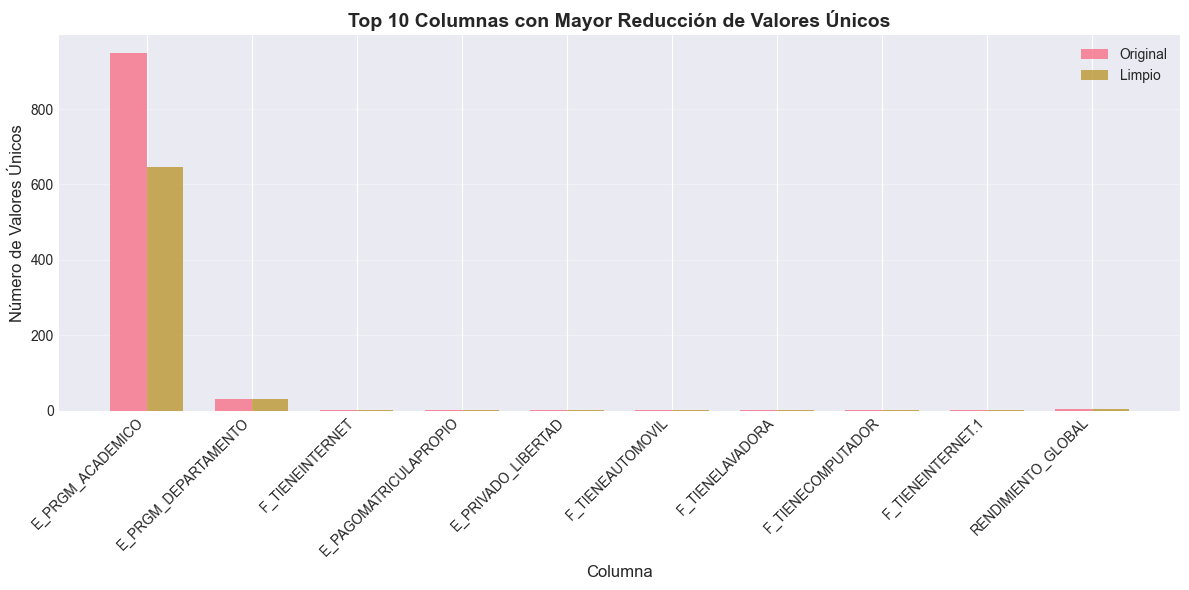

In [316]:
# Visualizar columnas con mayor reducción
top_mejoras = comparacion.nlargest(10, 'Reducción')

if len(top_mejoras[top_mejoras['Reducción'] > 0]) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = range(len(top_mejoras))
    width = 0.35
    
    ax.bar([i - width/2 for i in x], top_mejoras['Valores_Originales'], 
           width, label='Original', alpha=0.8)
    ax.bar([i + width/2 for i in x], top_mejoras['Valores_Limpios'], 
           width, label='Limpio', alpha=0.8)
    
    ax.set_xlabel('Columna', fontsize=12)
    ax.set_ylabel('Número de Valores Únicos', fontsize=12)
    ax.set_title('Top 10 Columnas con Mayor Reducción de Valores Únicos', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(top_mejoras['Columna'], rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No hubo reducciones significativas en las columnas categóricas")

## 8. Feature Engineering: Categorización de Programas Académicos

### 8.1 Problemática

Una de las columnas con mayor cardinalidad en el dataset es la de programas académicos, que puede contener entre 500-1000 valores únicos. Esta alta cardinalidad presenta varios desafíos:

- **Alta dimensionalidad**: Dificulta el entrenamiento de modelos
- **Datos dispersos**: Muchos programas tienen pocas observaciones
- **Variaciones menores**: "Ingeniería de Sistemas" vs "Ingeniería de Sistemas Computacionales" son esencialmente similares
- **Overfitting**: Modelos pueden memorizar programas específicos sin generalizar

In [317]:

print("="*80)
print("ANÁLISIS DE PROGRAMAS ACADÉMICOS")
print("="*80)

# Estadísticas básicas
total_programas = df_clean["E_PRGM_ACADEMICO"].nunique()
total_estudiantes = len(df_clean)

print(f"\n📊 Estadísticas Generales:")
print(f"  • Total de programas únicos: {total_programas:,}")
print(f"  • Total de estudiantes: {total_estudiantes:,}")
print(f"  • Promedio estudiantes por programa: {total_estudiantes/total_programas:.1f}")

# Top 15 programas más frecuentes
print(f"\n📈 Top 15 Programas Más Frecuentes:")
print("-"*80)
top_15 = df_clean["E_PRGM_ACADEMICO"].value_counts().head(15)
for i, (programa, count) in enumerate(top_15.items(), 1):
    pct = (count / total_estudiantes) * 100
    print(f"{i:2d}. {str(programa):50s} | {count:5,} ({pct:4.1f}%)")

# Análisis de concentración
top_10_pct = (top_15.head(10).sum() / total_estudiantes) * 100
print(f"\n💡 Los 10 programas más frecuentes representan el {top_10_pct:.1f}% de los estudiantes")

ANÁLISIS DE PROGRAMAS ACADÉMICOS

📊 Estadísticas Generales:
  • Total de programas únicos: 647
  • Total de estudiantes: 692,500
  • Promedio estudiantes por programa: 1070.3

📈 Top 15 Programas Más Frecuentes:
--------------------------------------------------------------------------------
 1. ADMINISTRACION DE EMPRESAS                         | 76,771 (11.1%)
 2. DERECHO                                            | 53,244 ( 7.7%)
 3. CONTADURIA PUBLICA                                 | 52,010 ( 7.5%)
 4. PSICOLOGIA                                         | 49,382 ( 7.1%)
 5. INGENIERIA INDUSTRIAL                              | 34,818 ( 5.0%)
 6. INGENIERIA CIVIL                                   | 21,315 ( 3.1%)
 7. MEDICINA                                           | 18,099 ( 2.6%)
 8. INGENIERIA DE SISTEMAS                             | 18,050 ( 2.6%)
 9. LICENCIATURA EN PEDAGOGIA INFANTIL                 | 15,580 ( 2.2%)
10. INGENIERIA AMBIENTAL                               | 13,

### 8.5 Implementación de la Clasificación

In [318]:
df_clean_pruebas = df_clean

def clasificar_programa_academico(programa):
    """
    Clasifica un programa académico en una categoría general.
    
    Estrategia: Búsqueda de palabras clave en orden jerárquico.
    - Primero busca categorías específicas (ej: Medicina)
    - Luego categorías generales (ej: Otras Ingenierías)
    - Finalmente asigna a 'Otros' si no coincide con ninguna
    
    Parámetros:
    ----------
    programa : str
        Nombre del programa académico
    
    Retorna:
    --------
    str : Categoría general del programa
    """
    if pd.isna(programa):
        return 'Desconocido'
    
    # Normalizar texto
    p = str(programa).lower()
    
    # Diccionario de categorías y palabras clave (orden específico -> general)
    categorias = {
        
        # Educación
        'Educación y Licenciaturas': ['educaci', 'licenciatura', 'pedagogia', 'docencia'],
        
        # Otras Ciencias de la Salud
        'Otras Ciencias de la Salud': ['quirur', 'salud', 'terapi', 'bacterio', 'optometr', 'higien'],

        # Administración
        'Administración de Empresas': ['administr', 'negocio', 'empresarial'],

        # Ingenierías específicas
        'Ingeniería de Sistemas y Computación': ['sistem', 'software', 'comput', 'informatic', 'telematic'],
        'Ingeniería Civil': ['civil'],
        'Ingeniería Industrial': ['industr'],
        'Ingeniería Eléctrica y Electrónica': ['electric', 'electron', 'el¿tric'],
        'Ingeniería Mecánica': ['mecanic', 'mecatronic'],
        'Ingeniería Química': ['quimic'],  # Debe tener ambas palabras
        'Ingeniería Ambiental': ['ambient'],
        'Otras Ingenierías': ['ingenier'],  # Catch-all para otras ingenierías
        
        # Ciencias de la Salud específicas
        'veterinaria': ['veterinar', 'zootec'],
        'Medicina': ['medicina'],
        'Enfermería': ['enferm'],
        'Odontología': ['odonto'],
        'Fisioterapia': ['fisioter'],
        'Nutrición': ['nutrici'],
        
        # Economía
        'Contaduría': ['contab', 'contadur'],
        'Economía': ['econom'],
        'Mercadeo': ['mercadeo', 'marketing'],
        'Finanzas': ['finanz'],
    
        # Ciencias Sociales y Humanas
        'Derecho': ['derecho', 'abogac', 'jurispruden'],
        'Psicología': ['psicolog'],
        'Trabajo Social': ['trabajo social'],
        'Sociología': ['sociol'],
        
        # Artes y Diseño
        'Arquitectura': ['arquitectura'],
        'Diseño': ['diseño'],
        'Artes': ['arte', 'musica', 'bellas artes', 'teatr'],
        
        # Comunicación
        'Comunicación Social': ['comunicaci', 'periodismo', 'publicidad'],
        
        # Deportes
        'deporte': ['deporte'],

        # Ciencias Básicas
        'Biología': ['biolog'],
        'Química': ['quimic'],  # Sin 'ingeniería'
        'Física': ['fisica'],
        'Matemáticas y Estadística': ['matemát','matemat', 'estadist'],
        
        # Ciencias Agropecuarias
        'Ciencias Agropecuarias': ['agrono', 'veterinar', 'zootec', 'agropec', 'agrícola'],
    }
    
    # Buscar coincidencias en orden
    for categoria, palabras_clave in categorias.items():
        if any(palabra in p for palabra in palabras_clave):
            return categoria
    
    return 'Otros'

# Aplicar clasificación
print("Aplicando clasificación de programas académicos...")
df_clean_pruebas['CATEGORIA_PROGRAMA'] = df_clean_pruebas["E_PRGM_ACADEMICO"].apply(clasificar_programa_academico)
print("✓ Clasificación completada")

# Resumen de la clasificación
n_categorias = df_clean_pruebas['CATEGORIA_PROGRAMA'].nunique()
n_originales = df_clean_pruebas["E_PRGM_ACADEMICO"].nunique()
reduccion = ((n_originales - n_categorias) / n_originales) * 100

print(f"\n📊 Resultados de la clasificación:")
print(f"  • Programas originales: {n_originales:,}")
print(f"  • Categorías generadas: {n_categorias}")
print(f"  • Reducción de dimensionalidad: {reduccion:.1f}%")

Aplicando clasificación de programas académicos...
✓ Clasificación completada

📊 Resultados de la clasificación:
  • Programas originales: 647
  • Categorías generadas: 34
  • Reducción de dimensionalidad: 94.7%


### 8.6 Visualizaciones

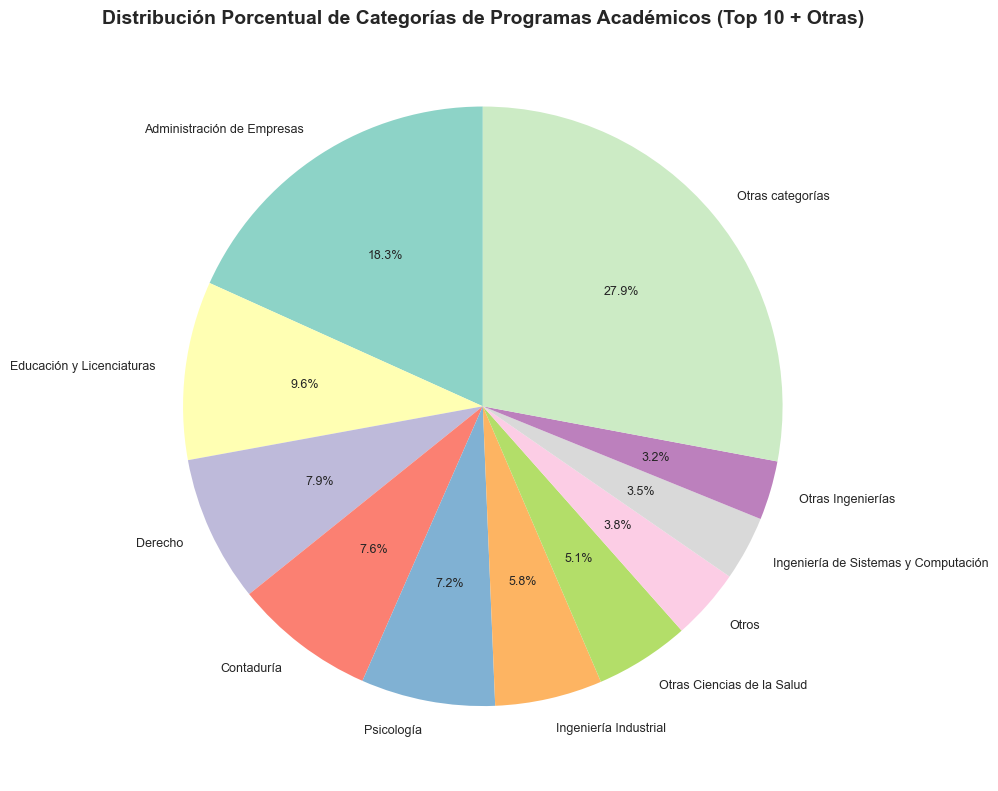

✓ Gráfico de torta generado con Seaborn (Top 10 + Otras categorías)


In [319]:
# Calcular conteo de categorías
cat_counts = df_clean['CATEGORIA_PROGRAMA'].value_counts()

# Agrupar las 10 más frecuentes y el resto como "Otras categorías"
top_10_cat = cat_counts.head(10)
otros = cat_counts.iloc[10:].sum()

if otros > 0:
    top_10_cat['Otras categorías'] = otros

# Convertir a DataFrame para facilitar con seaborn
df_pie = pd.DataFrame({
    'Categoría': top_10_cat.index,
    'Frecuencia': top_10_cat.values
})

# Paleta de colores de Seaborn
colors = sns.color_palette("Set3", len(df_pie))

# Crear gráfico tipo torta (pie chart)
plt.figure(figsize=(10, 10))
plt.pie(
    df_pie['Frecuencia'],
    labels=df_pie['Categoría'],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 9}
)

plt.title('Distribución Porcentual de Categorías de Programas Académicos (Top 10 + Otras)', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Gráfico de torta generado con Seaborn (Top 10 + Otras categorías)")


### 8.7 Validación de la Clasificación

Verificamos la calidad de la clasificación revisando algunos ejemplos de cada categoría.

In [320]:
print("="*80)
print("VALIDACIÓN: PROGRAMAS POR CATEGORÍA")
print("="*80)

# Obtener todas las categorías únicas
categorias_unicas = df_clean_pruebas['CATEGORIA_PROGRAMA'].value_counts().index

for categoria in categorias_unicas:
    print(f"\n📌 {categoria}")
    print("-" * 80)
    
    # Obtener todos los programas únicos de esta categoría
    programas_categoria = df_clean_pruebas[df_clean_pruebas['CATEGORIA_PROGRAMA'] == categoria]["E_PRGM_ACADEMICO"].unique()
    
    # Mostrar todos los programas con su número de estudiantes
    for i, programa in enumerate(sorted(programas_categoria), 1):
        count = len(df_clean_pruebas[df_clean_pruebas["E_PRGM_ACADEMICO"] == programa])
        print(f"  {i}. {programa:60s} ({count:,} estudiantes)")
    
    print(f"  Total: {len(programas_categoria)} programas distintos en esta categoría")


VALIDACIÓN: PROGRAMAS POR CATEGORÍA

📌 Administración de Empresas
--------------------------------------------------------------------------------
  1. 3° CICLO PROFESIONAL NEGOCIOS INTERNACIONALES                (69 estudiantes)
  2. ADMINISTRACION                                               (117 estudiantes)
  3. ADMINISTRACION & SERVICIO                                    (29 estudiantes)
  4. ADMINISTRACION AERONAUTICA                                   (78 estudiantes)
  5. ADMINISTRACION AGROPECUARIA                                  (117 estudiantes)
  6. ADMINISTRACION AMBIENTAL                                     (522 estudiantes)
  7. ADMINISTRACION AMBIENTAL Y DE LOS RECURSOS NATURALES         (249 estudiantes)
  8. ADMINISTRACION BANCARIA Y FINANCIERA                         (135 estudiantes)
  9. ADMINISTRACION COMERCIAL Y DE MERCADEO                       (483 estudiantes)
  10. ADMINISTRACION DE EMPRESAS                                   (76,771 estudiantes)
  11. ADMINI

## 9. Exportación de Datos Limpios

In [321]:
# Guardar dataset limpio
output_path = './data/train_clean.csv'
df_clean.to_csv(output_path, index=False)

print(f"✓ Dataset limpio guardado en: {output_path}")
print(f"\nDimensiones finales: {df_clean.shape}")
print(f"Filas: {df_clean.shape[0]:,}")
print(f"Columnas: {df_clean.shape[1]}")

# Resumen de nuevas columnas creadas
print(f"\n📊 Columnas añadidas durante el preprocesado:")
if 'CATEGORIA_PROGRAMA' in df_clean.columns:
    print(f"  ✓ CATEGORIA_PROGRAMA: Clasificación de programas académicos")

✓ Dataset limpio guardado en: ./data/train_clean.csv

Dimensiones finales: (692500, 22)
Filas: 692,500
Columnas: 22

📊 Columnas añadidas durante el preprocesado:
  ✓ CATEGORIA_PROGRAMA: Clasificación de programas académicos


---

## Referencias

- Dataset: [Kaggle - Pruebas Saber Pro Colombia](https://www.kaggle.com/competitions/udea-ai-4-eng-20252-pruebas-saber-pro-colombia)
- Fuzzy String Matching: [FuzzyWuzzy Documentation](https://github.com/seatgeek/fuzzywuzzy)
- Pandas Data Cleaning: [Pandas Documentation](https://pandas.pydata.org/docs/user_guide/missing_data.html)